# imports and setup

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# preliminary data cleaning 

In [6]:
# Read in the dataframe.
df_10_11 = pd.read_csv('data/dylan_data/play_by_play_2010_11.csv', encoding='latin1')
df_10_11.head()

,xg,event_id,event_type,event,secondary_type,event_team,event_team_type,description,period,period_seconds,...,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,venue_id
0,NaN,2.010020e+13,GAME_SCHEDULED,Game Scheduled,NaN,NaN,NaN,Game Scheduled,1,0,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
1,NaN,2.010020e+13,CHANGE,Change,NaN,Montréal Canadiens,away,"ON: Hal Gill, Scott Gomez, Brian Gionta, Josh ...",1,0,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
2,NaN,2.010020e+13,CHANGE,Change,Line change,Toronto Maple Leafs,home,"ON: Jean-Sebastien Giguere, Francois Beauchemi...",1,0,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
3,NaN,2.010020e+13,FACEOFF,Faceoff,NaN,Montréal Canadiens,away,Scott Gomez faceoff won against Tim Brent,1,0,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
4,NaN,2.010020e+13,HIT,Hit,NaN,Toronto Maple Leafs,home,Tim Brent hit Josh Gorges,1,15,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0


We see that this data is messy and contains a lot of unnecessary information. We will clean the data and remove the unnecessary information using the <code>get_data()</code> function (see <code>Appendix: Helper Functions</code>).

In [10]:
# Copy the dataframe (so we don't have to reload it)
df_copy = df_10_11.copy()

# Drop NaN's from event_team_type (drops events that are not helpful)
    # This includes things like game stats, end of periods, etc.
df_copy = df_copy.dropna(subset=['event_team'])

# Get all of the unique game ids, thus getting all of the games
unique_game_ids = df_10_11.game_id.unique()

# Get the label encoder for the teams
team_names = np.sort(df_copy.event_team.dropna().unique())  # Sort first to make sure the encoding is consistent
label_encoder = get_label_encoder(team_names)               # Get the label encoder (helper function)

# Label encode the teams
df_copy['team_encoded'] = label_encoder.transform(df_copy.event_team)

# Iterate through the games
final_df = pd.DataFrame()
for game_id in unique_game_ids:
    home_df, away_df = get_data(df_copy, game_id)
    final_df = final_df.append(home_df)
    final_df = final_df.append(away_df)

The <code>get_data()</code> function creates a state-vector for each team in each game (home and away). The data points we have determined to be important are faceoff, hit, giveaway, blocked_shot, shot, missed_shot, goal, takeaway, penalty, time_remaining, team. Each of these features is essentially a count of the number of times that event occurred in the current game (exluding team, which is unchanging). We can view what this dictionary now looks like (see <code>2. Data Examination</code>).

# Data Cleaning Descriptive Statistics Tasks

**1. Train-Test**

Before doing any exploration, consider when and how you plan on holding out data for model evaluation. The gold standard is to have totally independent data you have never seen before tucked away so you can evaluate model performance at the end, but there can be many reasons this may not work. Explain your choice. If you do want to hold out the same data every time, consider fixing a random seed when you make the test-train split.

In [40]:
'''
The way we decided to train_test split our data is to use the last half of our most recent season as our test set.
Our plan is to use all historical data in our model. The main reason for this is because how well a team does
in a previous year is a good indicator of how well they will do in the next year. So, we will use data from previous
years to help predict the outcome of current games. By excluding the second half of our current season, we can
simulate how our model would perform in a real world scenario. As an example of how this is done, we will train test split 
the example dataframe (from the 2010-2011 season) as an example of how this will be done.
'''
train_df, test_df = final_df.iloc[:328227], final_df.iloc[328227:]

# We can now split the data into features and labels
X_train, y_train = train_df.drop(['WIN'], axis=1), train_df['WIN']
X_test, y_test = test_df.drop('WIN', axis=1), test_df['WIN']

**2. Data Examination**

Print out a few dozen rows of the data. Is there anything you didn't expect to see? What opportunities for data cleaning and feature engineering may be important? Take care of these things.

Our helper function <code>get_data()</code> has already cleaned the data for us. However, there is still room for feature engineering. Some potential features are

- Power play percentage (how good a team is at scoring when they have a powerplay)
- Penalty kill percentage (how good a team is at preventing goals when they are on the penalty kill)
- Momentum (what is the change of data in the last 5 minutes of the game)
- Time of possession (how long a team has the puck)  <-- This one will require a different dataset.


In [41]:
display(X_train.head())
display(y_train.head())

,index,FACEOFF,HIT,GIVEAWAY,BLOCKED_SHOT,SHOT,MISSED_SHOT,GOAL,TAKEAWAY,PENALTY,TIME_REMAINING,HOME,TEAM,GAME_ID
0,0,0,1,0,0,0,0,0,0,0,3585,1,27,2010020001
1,1,0,1,1,0,0,0,0,0,0,3531,1,27,2010020001
2,2,0,1,1,1,0,0,0,0,0,3492,1,27,2010020001
3,3,0,1,2,1,0,0,0,0,0,3429,1,27,2010020001
4,4,1,1,2,1,0,0,0,0,0,3333,1,27,2010020001


0    1
1    1
2    1
3    1
4    1
Name: WIN, dtype: object

**3. Time Series Examination**

Plot a few individual time series and do a similar check. Is there anything unbelievable you see?

The easiest way to see if things make sense is to plot the change in the state vector over the course of a game. We can do this by plotting the state vector for each team in a randomly selected game.

We do this using the <code>plot_game()</code> function (see <code>Appendix: Helper Functions</code>). This function plots each element of the state vector for each team over the course of the game. As we expect, the only feature that decreases overtime is time_remaining. The other features should either increase or stay stagnant for each time set. We can see that this is the case for the game we have selected. Since this game was randomly selected, we can assume that this is the case for all games.

In [81]:
# Select a random game to visualize
selected_game = X_train.GAME_ID.sample(1).values

# Get the selected game
selected_game_df = X_train[X_train.GAME_ID == selected_game[0]]

# Break the selected game into home and away teams
home_team_selected = selected_game_df[selected_game_df.HOME == 1]
away_team_selected = selected_game_df[selected_game_df.HOME == 0]

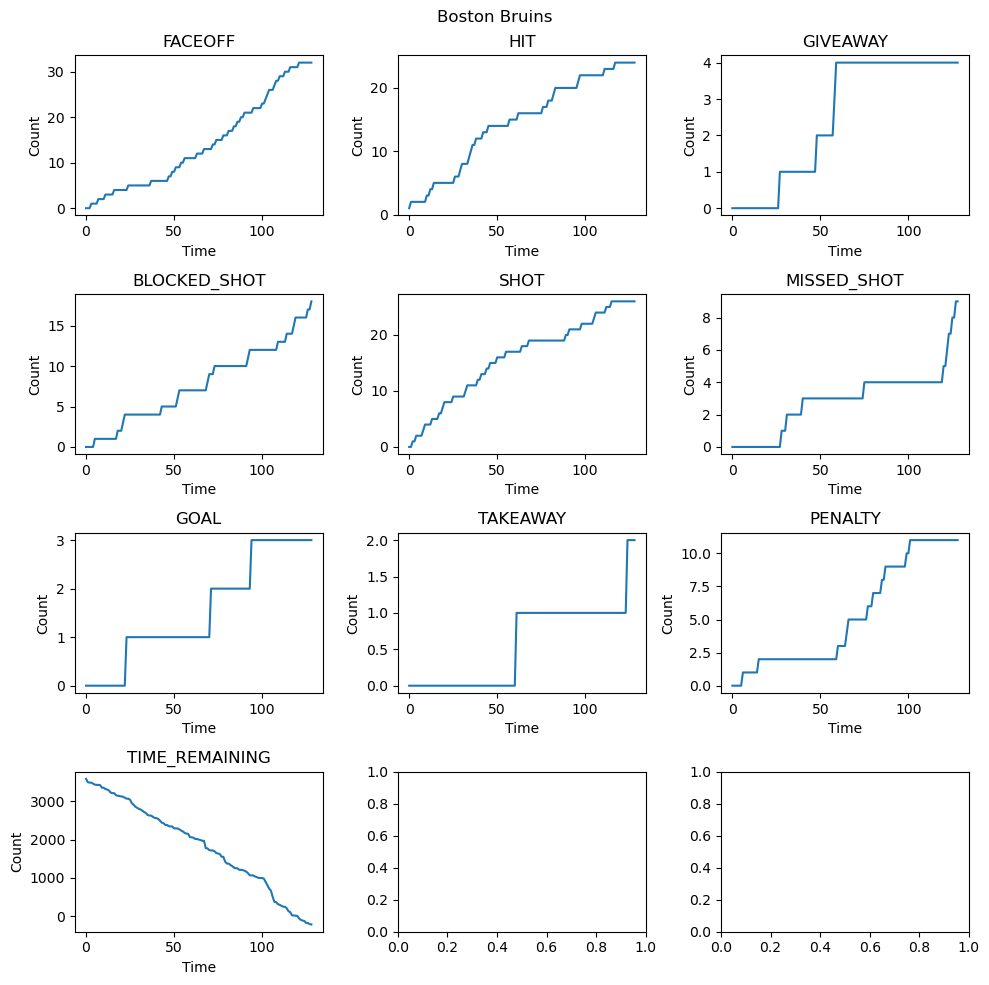

In [78]:
# Plot for the home team
# Get rid of extra columns
team_id = home_team_selected.TEAM.unique()[0]
home_team_plot = home_team_selected.drop(columns=['index', 'HOME', 'GAME_ID', 'TEAM'])

# Plot the game (helper function)
plot_game(home_team_plot, team_id)

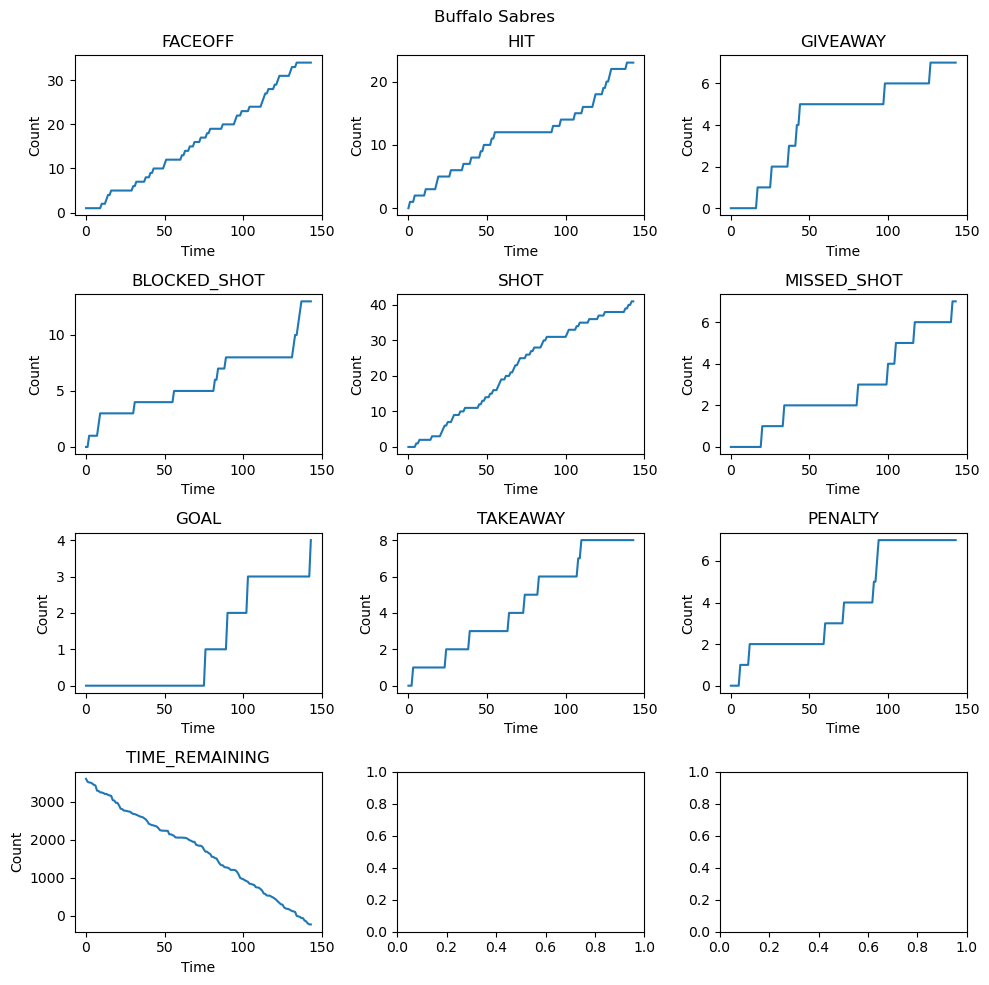

In [80]:
# Plot for the away team
# Get rid of extra columns
team_id = away_team_selected.TEAM.unique()[0]
away_team_plot = away_team_selected.drop(columns=['index', 'HOME', 'GAME_ID', 'TEAM'])

# Plot the game (helper function)
plot_game(away_team_plot, team_id)

**4. Missing data**

How much data is missing? Is the distribution of missing data likely different from the distribution of non-missing data? How might you do a meaningful imputation (if needed)? Are there variables that should be dropped? Implement some initial solutions.

So far in our data exploration we have not found any missing data. In our <code>get_data()</code> function, we have a line that drops all rows with NaN values in the <code>event_team_type</code> column. This is done to remove any rows that do not contain important data. For example, when a game starts, a period ends, or a game ends, the <code>event_team_type</code> column is NaN. We can see that this is the case for all games. Thus, since none of those events are important features for our analysis, we can drop them without much thought.

**5. Data vs. Application**

Is there any hint that the data you have collected is differently distributed from the actual application of interest? If so, is there a strategy, such as reweighing samples, that might help?

No. As this is live game data, and we are interested in predicting events for live games, this data has the exact distribution that we need. And based on the graphs shown here, the data is believeable and we see no reason to believe that it is not actually game data.

**6. Histogram/KDE and outliers**

Use a histogram or KDE to visualize the distribution of key variables. Consider log-scaling or other scaling of the axes. How should you think about outliers? Is there a natural scaling for certain variables?

To do this, we can randomly select a few teams and plot the histogram for each feature throughout the whole season. We expect to see a pretty heavy right skew for most of the features. This is because most of the features are counts of events that occur in a game, initially starting at 0.

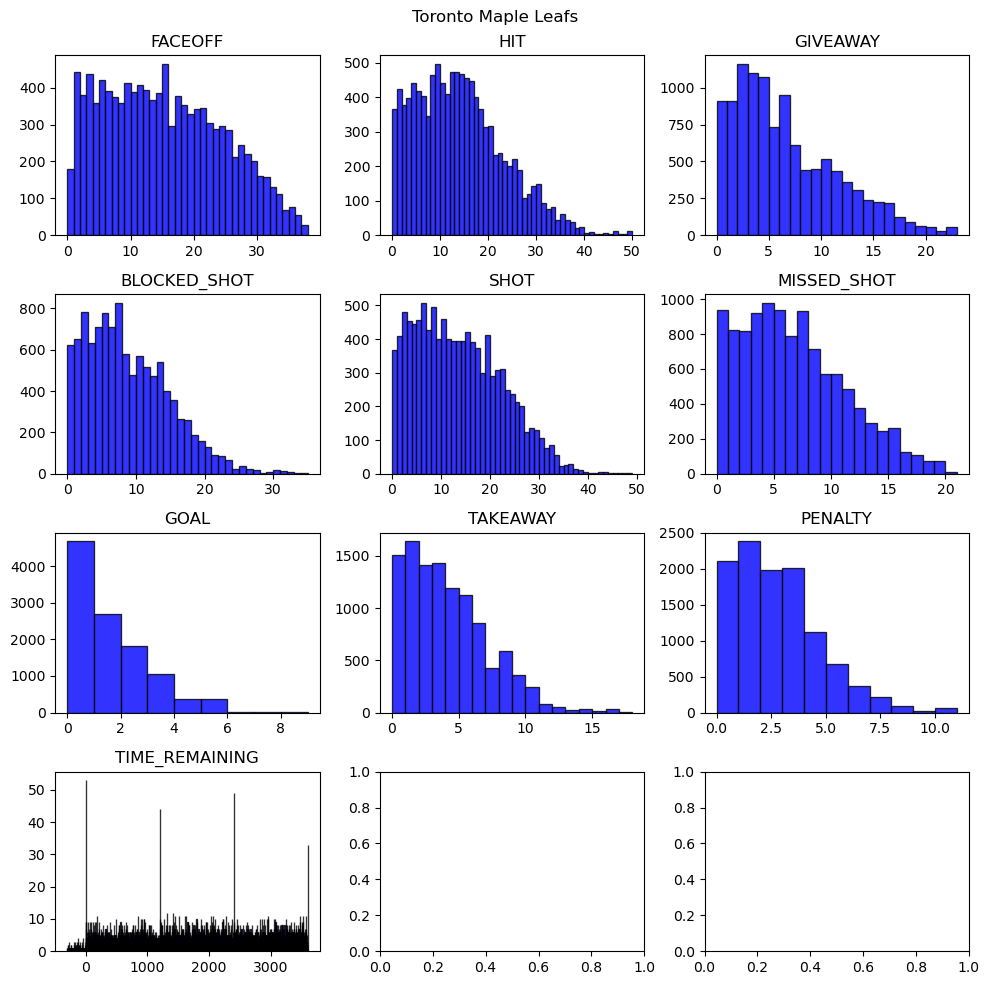

In [173]:
# Randomly select two teams to plot
team_1 = X_train.TEAM.unique()[0]
team_2 = X_train.TEAM.unique()[1]

# Get the games for the two teams
team_1_games = X_train[X_train.TEAM == team_1]
team_2_games = X_train[X_train.TEAM == team_2]

# Drop the extra columns
team_1_games = team_1_games.drop(columns=['index', 'HOME', 'GAME_ID', 'TEAM'])
team_2_games = team_2_games.drop(columns=['index', 'HOME', 'GAME_ID', 'TEAM'])

# Plot the hist for the first team.
plot_hist(team_1_games, team_1)

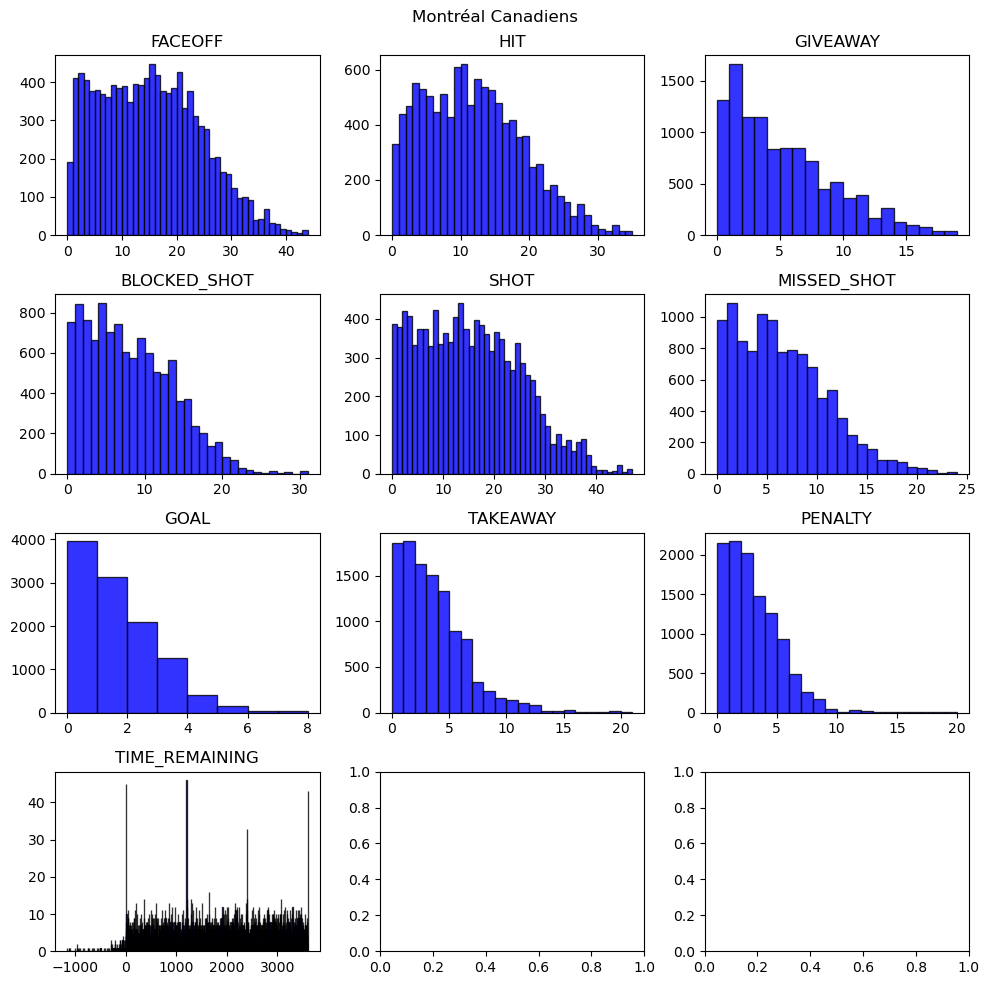

In [174]:
# Plot the hist for the second team.
plot_hist(team_2_games, team_2)

For time remaining, negative time corresponds to overtime.

We now look at the distribution of the same features above (excluding time remaining) for all of our data to get a better understanding of the distribution for the whole league.

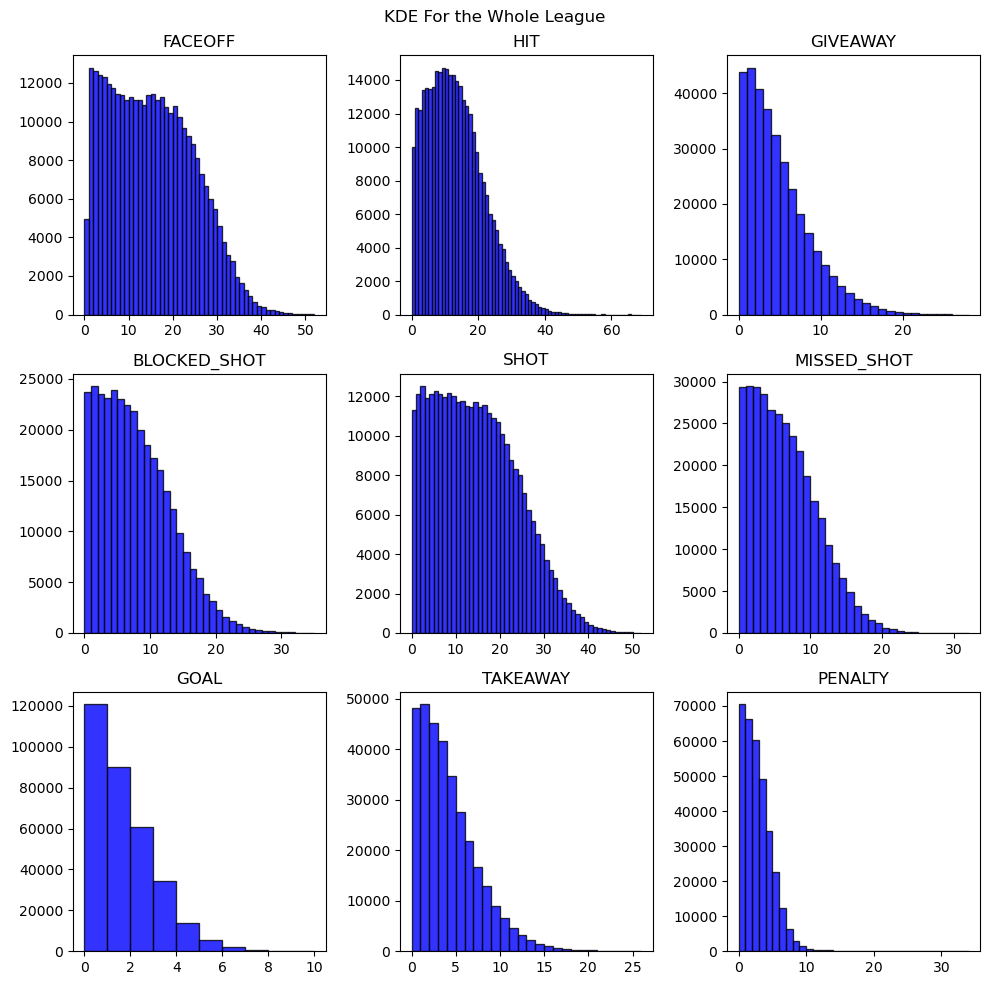

In [175]:
# Plot the whole league.
league_dists = X_train.drop(columns=['index', 'HOME', 'GAME_ID', 'TEAM', 'TIME_REMAINING'])
plot_hist(league_dists, 'KDE For the Whole League')

**7. Relationships**

Use 2D and/or 3D plot scatter plots, histograms, or heat maps to look for important relationships between variables. Consider using significance tests, linear model fits, or correlation matrices to clarify relationships.

One of the first things we will do is do a correlation matrix for all of the features. To do this, we will get a subset of data that only includes the ending state vector for each game. We will then do a correlation matrix on this subset of data.

In [140]:
# Get a dataframe that just has the ending state vector for each game in our training data.
# We drop the index, time remaining, and game id columns.
ending_state_per_game = X_train.groupby(['HOME', 'GAME_ID']).tail(1).drop(columns=['index', 'TIME_REMAINING', 'GAME_ID'])

# Convert each of these values to integers
ending_state_per_game = ending_state_per_game.astype(int)

# Create a correlation matrix for these ending vectors
corr_matrix = ending_state_per_game.drop(columns=['HOME', 'TEAM']).corr()
corr_matrix

,FACEOFF,HIT,GIVEAWAY,BLOCKED_SHOT,SHOT,MISSED_SHOT,GOAL,TAKEAWAY,PENALTY
FACEOFF,1.000000,0.051900,0.063562,0.149849,0.237220,0.167457,0.177765,0.068832,0.083485
HIT,0.051900,1.000000,0.000588,0.074176,0.017125,0.074115,-0.053945,0.007997,0.012464
GIVEAWAY,0.063562,0.000588,1.000000,0.144243,0.058906,0.131860,-0.037907,0.268601,-0.054195
BLOCKED_SHOT,0.149849,0.074176,0.144243,1.000000,0.257282,0.270056,-0.183110,0.113115,-0.051015
SHOT,0.237220,0.017125,0.058906,0.257282,1.000000,0.257440,-0.098345,0.072667,-0.099398
MISSED_SHOT,0.167457,0.074115,0.131860,0.270056,0.257440,1.000000,-0.096852,0.015621,-0.058358
GOAL,0.177765,-0.053945,-0.037907,-0.183110,-0.098345,-0.096852,1.000000,0.085918,0.090990
TAKEAWAY,0.068832,0.007997,0.268601,0.113115,0.072667,0.015621,0.085918,1.000000,-0.046930
PENALTY,0.083485,0.012464,-0.054195,-0.051015,-0.099398,-0.058358,0.090990,-0.046930,1.000000


Interpreting these results is interesting. None of the variables appear to be highly correlated, with the maximum correlation being 0.270056 being between missed_shot and blocked_shot. But even then, this is not a very high correlation. If we instead create a correlation matrix for every entry (not just the ending state vector), we get:

In [118]:
# Drop unnecessary columns for our problem.
subset_df = X_train.drop(columns=['index', 'GAME_ID', 'HOME', 'TEAM'])

# Convert the dataframe to integers
subset_df = subset_df.astype(int)

# Create a correlation matrix for the subset dataframe
corr_matrix = subset_df.corr()
corr_matrix

,FACEOFF,HIT,GIVEAWAY,BLOCKED_SHOT,SHOT,MISSED_SHOT,GOAL,TAKEAWAY,PENALTY,TIME_REMAINING
FACEOFF,1.000000,0.734616,0.580440,0.756351,0.843311,0.742229,0.565016,0.588805,0.633922,-0.911818
HIT,0.734616,1.000000,0.491475,0.642769,0.692392,0.637414,0.421600,0.495005,0.522302,-0.801822
GIVEAWAY,0.580440,0.491475,1.000000,0.539919,0.554279,0.527803,0.333994,0.536402,0.379895,-0.627231
BLOCKED_SHOT,0.756351,0.642769,0.539919,1.000000,0.752895,0.696661,0.390598,0.542280,0.494675,-0.799651
SHOT,0.843311,0.692392,0.554279,0.752895,1.000000,0.739660,0.482090,0.577913,0.547059,-0.881090
MISSED_SHOT,0.742229,0.637414,0.527803,0.696661,0.739660,1.000000,0.406508,0.500215,0.482200,-0.787612
GOAL,0.565016,0.421600,0.333994,0.390598,0.482090,0.406508,1.000000,0.397215,0.415225,-0.557821
TAKEAWAY,0.588805,0.495005,0.536402,0.542280,0.577913,0.500215,0.397215,1.000000,0.408579,-0.634788
PENALTY,0.633922,0.522302,0.379895,0.494675,0.547059,0.482200,0.415225,0.408579,1.000000,-0.657513
TIME_REMAINING,-0.911818,-0.801822,-0.627231,-0.799651,-0.881090,-0.787612,-0.557821,-0.634788,-0.657513,1.000000


This produces more interesting results. For example, we see that there is a higher correlation between faceoff and shot. This makes sense because if a team wins a faceoff (especially if they are in the opposing teams end) they are much more likely to shoot the puck. In fact, we see a decently high correlation between faceoff and the other types of shots (blocked and missed).

Another interesting correlation is actually the inverse correlation between time remaining and the other features. Before looking at the data, let's talk about what happens when a game is about to end. Typically in the last few minutes of a game, the team that is losing will pull their goalie. This means that they will have an extra attacker on the ice, meaning they are more likely to control the puck. Because of their desperation to score, there is much more action than the rest of the game. So, we expect the team to shoot the puck more (this leads to more blocked shots, shots, and missed shots). This will increase the chance the goalie freezes the puck (stops the play), which results in more faceoffs (everytime the puck is frozen, a faceoff occurs). Now, turning our attention back to the TIME_REMAINING column of our correlation matrix, we see that there is a negative correlation between time remaining and all of the other features. This is exactly what we expect to see.

Another correlation we expect to see is between faceoffs, shots, and goals; takeaways and goals; shots, goals, and wins; and wins and if the team is the home team or not. We will look at these correlations by a few plots.

In [141]:
# Get our working subset.
subset_df = X_train.drop(columns=['index']).copy()

# Merge with our labels (because we are looking at wins).
subset_df['WIN'] = y_train

# Get the last row for each game.
subset_df = subset_df.groupby(['HOME', 'GAME_ID']).tail(1)

# Create a list of the columns we want to look at.
columns_to_look_at = [['FACEOFF', 'SHOT', 'GOAL'], ['TAKEAWAY', 'GOAL'], ['SHOT', 'GOAL', 'WIN'], ['HOME', 'WIN']]

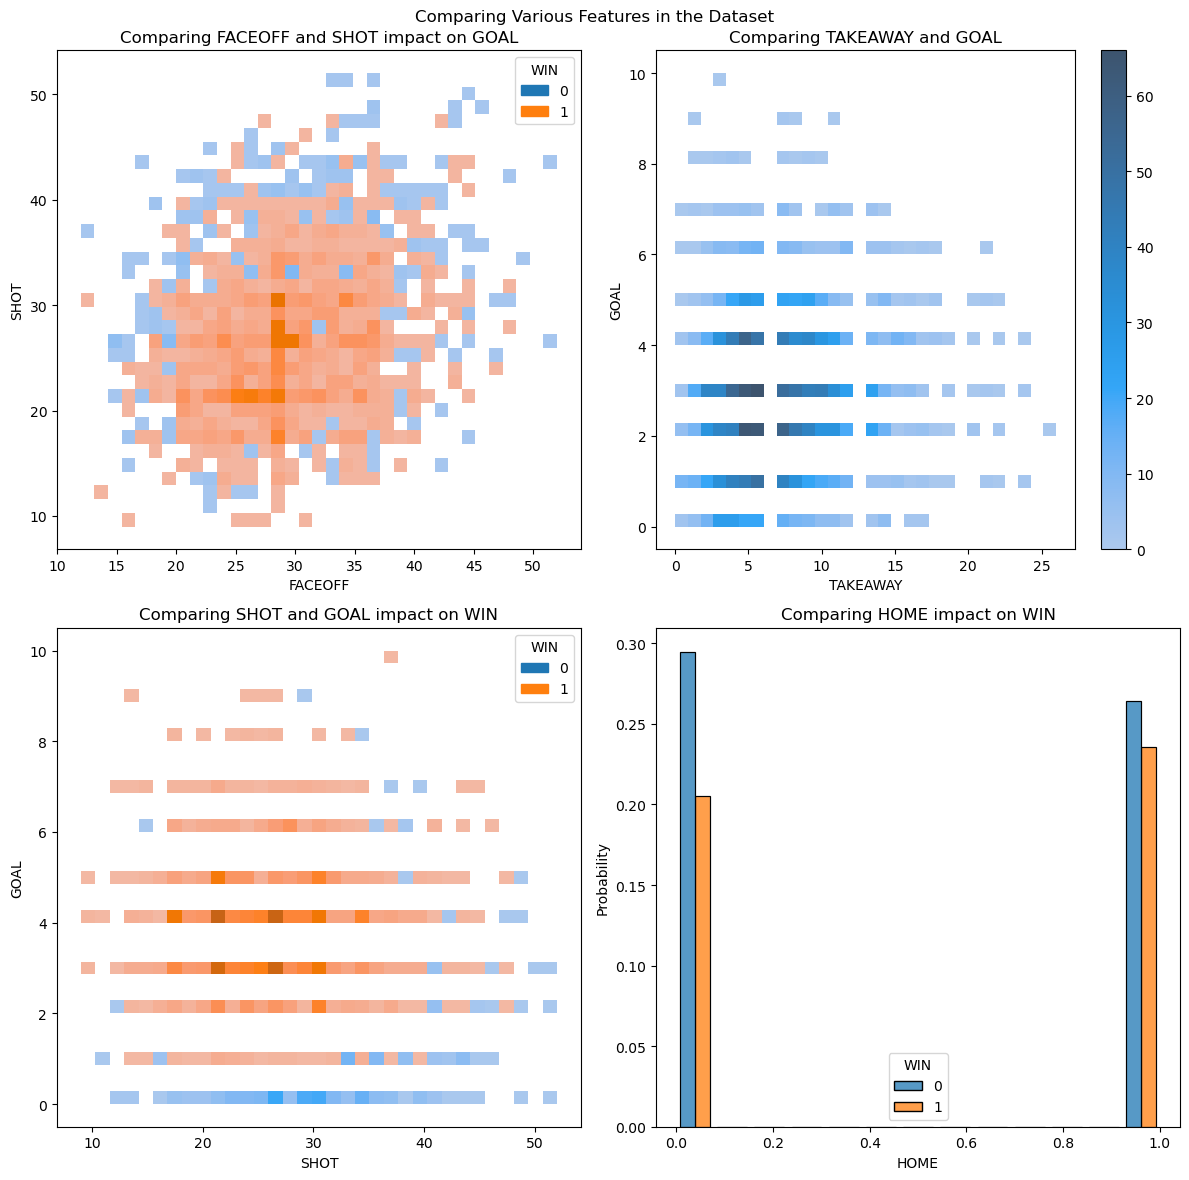

In [149]:
# Create 2-d scatter plots for each set of columns.
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
num_cols = 2
for i, columns in enumerate(columns_to_look_at):
    # Get the current row and column
    row = i // num_cols
    col = i % num_cols
    
    # If we have categorical data, use a histogram
    if i == len(columns_to_look_at) - 1:
        sns.histplot(data=subset_df, x=columns[0], hue=columns[1], multiple="dodge", ax=ax[row, col], stat='probability', shrink=0.8)
        ax[row, col].set_title(f'Comparing {columns[0]} impact on WIN')
        continue
        
    
    if len(columns) == 3:
        sns.histplot(data=subset_df, x=columns[0], y=columns[1], hue='WIN', ax=ax[row, col])
        ax[row, col].set_title(f'Comparing {columns[0]} and {columns[1]} impact on {columns[2]}')
    elif len(columns) == 2:
        sns.histplot(data=subset_df, x=columns[0], y=columns[1], ax=ax[row, col], cbar=True)
        ax[row, col].set_title(f'Comparing {columns[0]} and {columns[1]}')

plt.suptitle('Comparing Various Features in the Dataset')
plt.tight_layout()
plt.show()

The bottom right plot would seem to suggest that you are more likely to lose both home and away, which doesn't make sense, however, this is a sum of the final outcome based on every recorded event, and there are more away events than home, so more overall loss events than win events overall. In summary, the bottom right histogram is a bad way of displaying the data, but doesn't show any apparent error in the data.

**8. Model selection**

Does what you see change any of your ideas for what models might be appropriate? Among other things, if your models rely on specific assumptions, is there a way you can check if these assumptions actually hold by looking at the data? If you are using linear models, do the relevant plots look linear? Is there some other scaling where the model assumptions might more nearly hold?

Looking at and analyzing our data, the question we want to analyze becomes clearer to us. As we see above, we have clear time series for games that are updated whenever an event is recorded. So the question that we want to answer on the data, is given a current 'state', what is the probability that the home team wins? This is can be formulated as $P(\text{win}|x_t)$ where $x_t$ corresponds to the current state vector of all the events shown above. We can use several different predictive methods for this question, such as random forests or logistic regression. We are also interested in sampling from this 'posterior' distribution using MCMC methods, or forecasting treating the 'probability' as a hidden state and the state vector as the observed state

# Appendix: Helper Functions

In [172]:
def get_data(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])

    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID'])

    # Create dictionaries to store event counts for home and away teams
    home_dict = {event: 0 for event in event_types}
    away_dict = {event: 0 for event in event_types}

    # Create DataFrames to store event data for home and away teams
    home_df = pd.DataFrame(columns=home_dict.keys())
    away_df = pd.DataFrame(columns=away_dict.keys())

    # Iterate through the events in the game and count them
    for _, row in game1.iterrows():
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(row['event_team_type']) or row['event_type'] == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if row['event_team_type'] == 'home':
            home_dict[row['event_type']] += 1
            home_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            home_dict['HOME'] = 1
            home_dict['WIN'] = 1 if row['home_final'] > row['away_final'] else 0
            home_dict['TEAM'] = row['team_encoded']
            home_dict['GAME_ID'] = game_id
            home_df = home_df.append(home_dict, ignore_index=True)
        else:
            away_dict[row['event_type']] += 1
            away_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            away_dict['HOME'] = 0
            away_dict['WIN'] = 1 if row['home_final'] < row['away_final'] else 0
            away_dict['TEAM'] = row['team_encoded']
            away_dict['GAME_ID'] = game_id
            away_df = away_df.append(away_dict, ignore_index=True)
        
    return home_df, away_df


def get_label_encoder(teams):
    le = LabelEncoder()
    le.fit(teams)
    return le


def plot_game(team, team_id):
    """
    Plot the data for a given team.

    Parameters:
        team (DataFrame): The data for the team to be plotted.
        team_id (int): The ID of the team.

    Returns:
        None: This function displays the plot but does not return any value.
    """

    # Get the columns we need to plot.
    plot_names = team.columns
    
    # Get the number of rows and columns necessary for the plot
    num_cols = 3
    num_rows = len(plot_names) // num_cols + 1 if len(plot_names) % num_cols != 0 else len(plot_names) // num_cols
    
    # Create the plot
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    
    # Get x-axis values
    x = range(len(team))
    
    # Iterate through the columns and plot them
    for i, column in enumerate(plot_names):
        row = i // num_cols
        col = i % num_cols
        ax[row, col].plot(x, team[column])
        ax[row, col].set_title(column)
        ax[row, col].set_xlabel('Time')
        ax[row, col].set_ylabel('Count')
    
    # Set the title
    fig.suptitle(label_encoder.inverse_transform([team_id])[0])  # Assuming label_encoder is defined elsewhere
    plt.tight_layout()
    plt.show()


def plot_hist(team, team_id, normalize=False):
    """
    Plot Histogram Density plots for each column of the team data.

    Parameters:
        team (DataFrame): The data for the team to be plotted.
        team_id (int): The ID of the team.

    Returns:
        None: This function displays the plot but does not return any value.
    """
    
    # Get the columns we need to plot.
    plot_names = team.columns
    
    # Get the number of rows and columns necessary for the plot
    num_cols = 3
    num_rows = len(plot_names) // num_cols + 1 if len(plot_names) % num_cols != 0 else len(plot_names) // num_cols
    
    # Create the plot
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    
    # Iterate through the columns and plot the KDE for each
    for i, column in enumerate(plot_names):
        row = i // num_cols
        col = i % num_cols
        
        # Plot the histogram
        ax[row, col].hist(team[column], bins=len(team[column].unique())-1, alpha=0.8, color='blue', edgecolor='black', lw=0.96, density=normalize)
        ax[row, col].set_title(column)
        
    # Set the main title of the plot
    if type(team_id) == str:
        fig.suptitle(team_id)
    else:
        plt.suptitle(label_encoder.inverse_transform([team_id])[0])  # Assuming label_encoder is defined elsewhere
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
